In [1]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:\Work_with_MM")

# Verify the change
print(os.getcwd())

H:\Work_with_MM


FileNotFoundError: [Errno 2] No such file or directory: '/home/sandbox/predictor_importance_visualization.png'

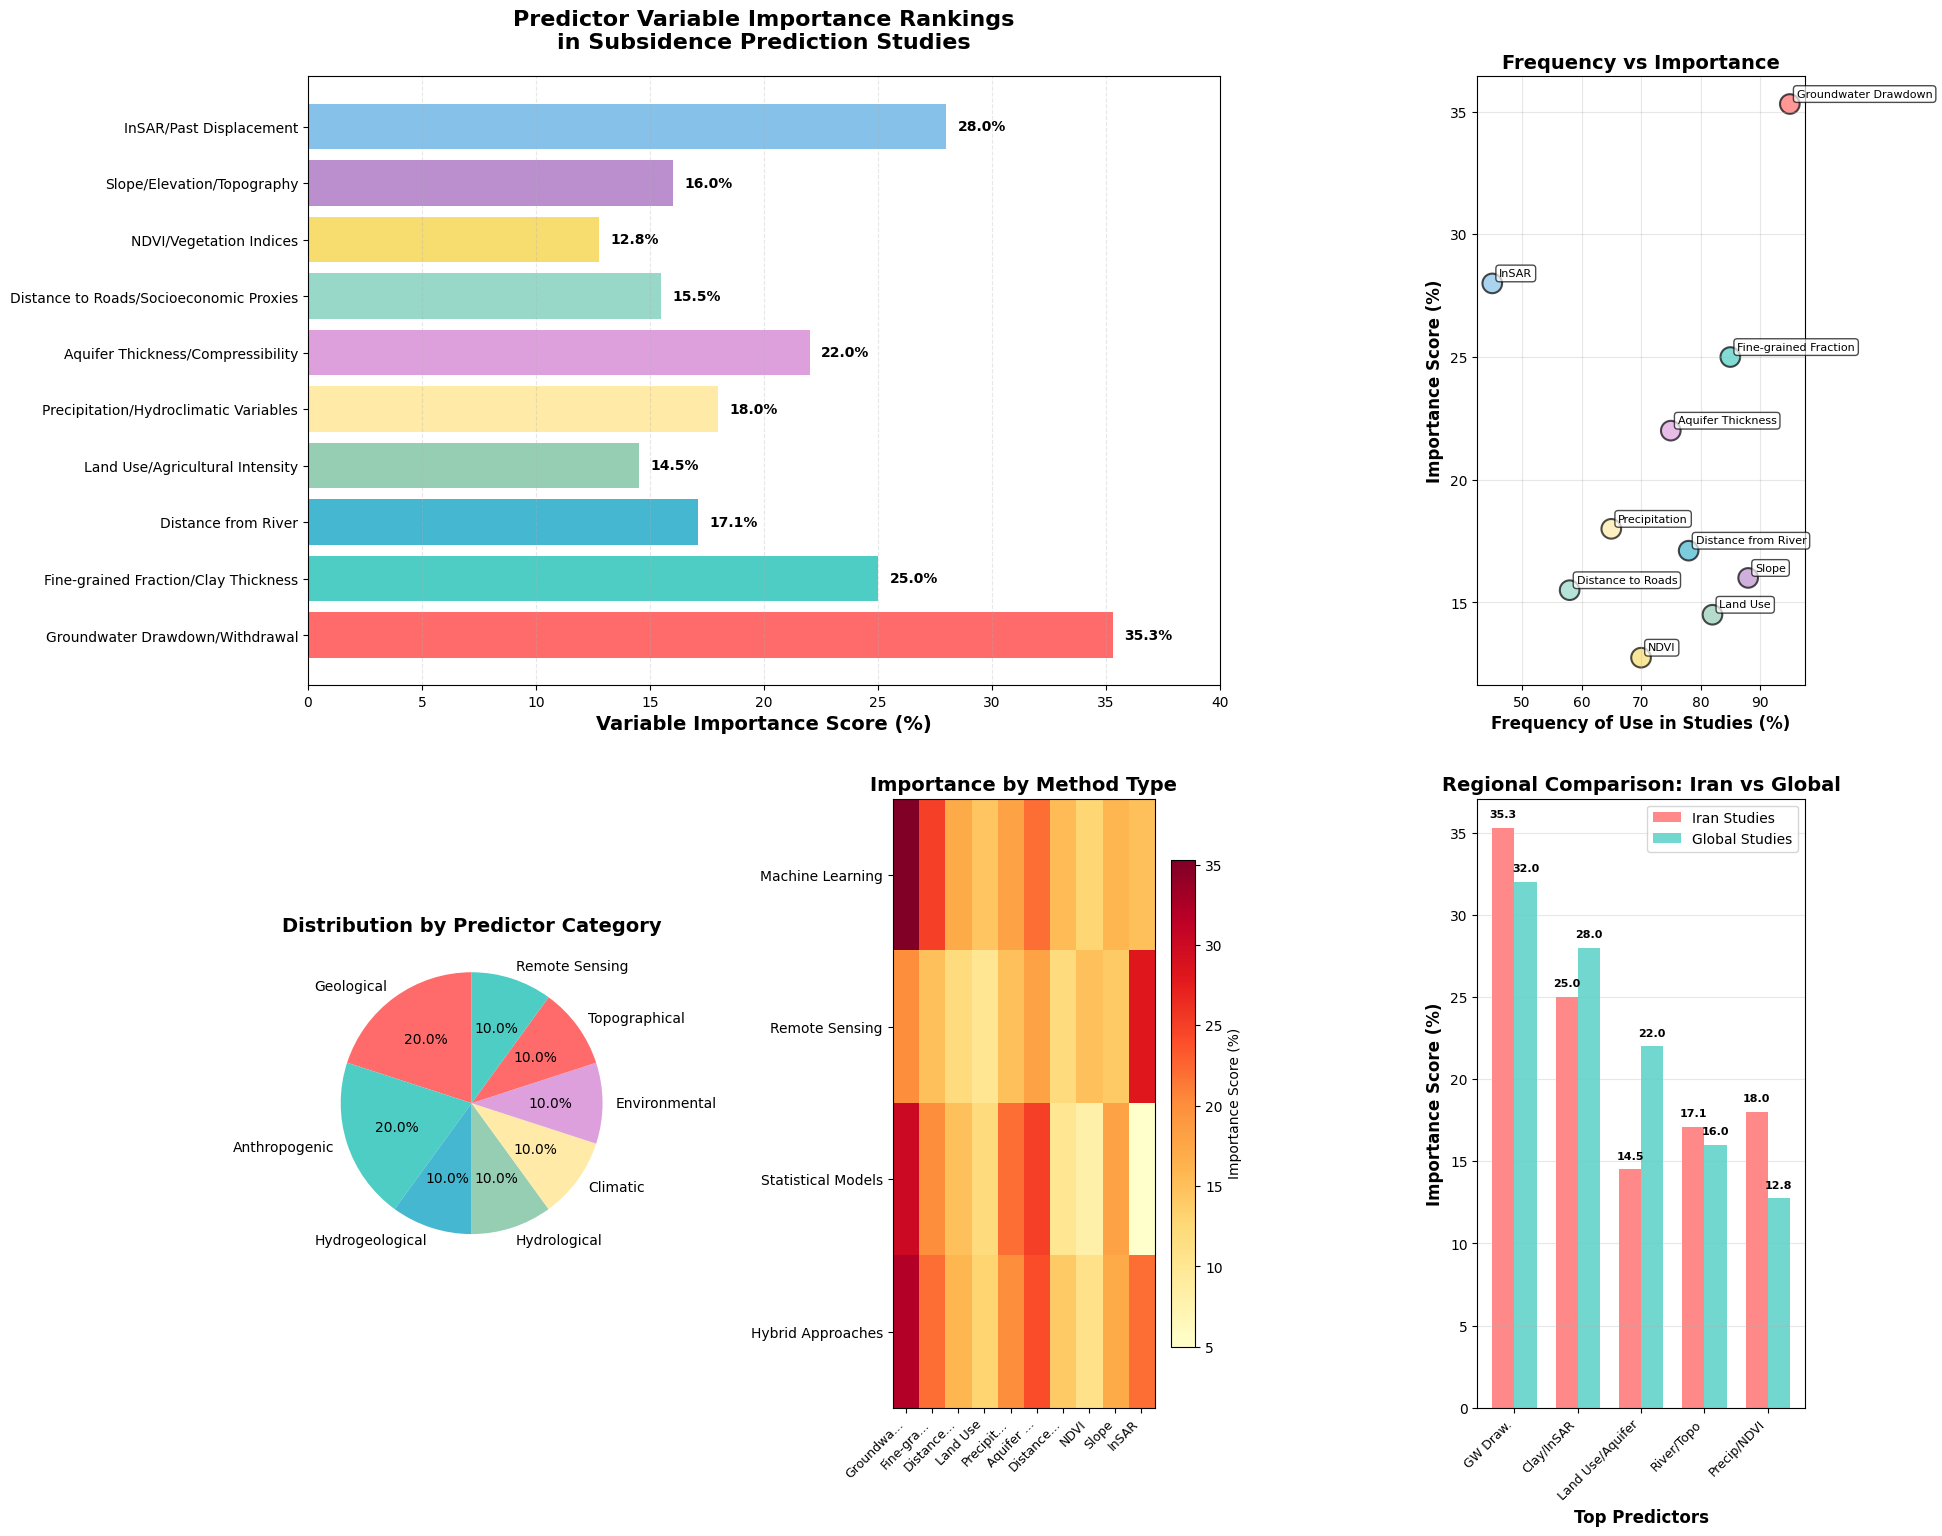

In [ ]:
# time seri Plot


In [12]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/lisfoold/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Lisflood_2000_2025.csv")
OUTPUT_DIR = "Time_Seri_Charts"

# Define target coordinates and file structure
TARGET_LAT = 31.333
TARGET_LON = 48.683

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define distinct colors for each climate model for consistent plotting
MODEL_COLORS = {
    "GFDL": "#1f77b4",  # Blue
    "IPSL": "#ff7f0e",  # Orange
    "MPI": "#2ca02c",  # Green
    "MRI": "#9467bd",  # Purple
    "ukesm": "#8c564b"  # Brown
}

# --- 2. Load and Pre-process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    obs_df = pd.read_csv(file_path)
    obs_df['Date'] = pd.to_datetime(obs_df['Date'])
    obs_df.set_index('Date', inplace=True)
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'discharge_obs'}, inplace=True)
    return obs_df

# --- 3. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads, processes, and resamples the discharge data for a given scenario.
    Returns daily, monthly, seasonal, and annual dataframes with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                # Select the nearest grid point to the target coordinates
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                # Convert to pandas Series and rename for clarity
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None, None, None, None
    
    # Concatenate all model time series into a single DataFrame
    df_daily = pd.concat(data_daily, axis=1)
    
    # Resample daily data to other frequencies
    df_monthly = df_daily.resample('M').mean()
    df_seasonal = df_daily.resample('QS-DEC').mean() # Quarterly, starting in December
    df_annual = df_daily.resample('A').mean()
    
    return df_daily, df_monthly, df_seasonal, df_annual

# --- 4. Plotting Functions for Each Time Resolution ---
def plot_time_series(ax, obs_data, forecast_df, title, y_label):
    """Helper function to plot data with consistent styling."""
    
    # Plot observational data
    ax.plot(obs_data.index, obs_data['discharge_obs'], label='Observed Discharge', color='black', linewidth=1.5, zorder=5)
    
    # Plot each individual model's forecast
    for model in GCM_MODELS:
        if model in forecast_df.columns:
            ax.plot(
                forecast_df.index,
                forecast_df[model],
                label=f'{model} Forecast',
                color=MODEL_COLORS.get(model, 'gray'),
                linestyle='-',
                alpha=0.8,
                linewidth=1,
                zorder=2
            )
    
    # Set plot aesthetics
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a unified legend
    ax.legend(loc='upper right', fontsize=10, ncol=2)
    
    # Highlight the overlap period
    ax.axvspan(obs_data.index.min(), obs_data.index.max(), color='grey', alpha=0.1, zorder=0)

    plt.tight_layout()

# --- 5. Main Execution Block ---
if __name__ == "__main__":
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the single observational dataset
    obs_df = load_obs_data(OBS_FILE)
    
    # Process and plot for each scenario
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        # Get processed data for all time resolutions
        df_daily, df_monthly, df_seasonal, df_annual = process_gcm_data(scenario_code)
        
        if df_daily is not None:
            # Create plots for each time resolution
            plots_to_create = {
                "daily": (df_daily, obs_df, 'Daily River Discharge', 'Discharge ($m^3/s$)'),
                "monthly": (df_monthly, obs_df.resample('M').mean(), 'Monthly River Discharge', 'Average Monthly Discharge ($m^3/s$)'),
                "seasonal": (df_seasonal, obs_df.resample('QS-DEC').mean(), 'Seasonal River Discharge', 'Average Seasonal Discharge ($m^3/s$)'),
                "annual": (df_annual, obs_df.resample('A').mean(), 'Annual River Discharge', 'Average Annual Discharge ($m^3/s$)')
            }
            
            for resolution, (forecast_data, obs_data, title_prefix, y_label) in plots_to_create.items():
                fig, ax = plt.subplots(figsize=(15, 8))
                plot_time_series(
                    ax,
                    obs_data,
                    forecast_data,
                    title=f'{title_prefix} Forecast: {scenario_name.capitalize()} Scenario',
                    y_label=y_label,
                )
                
                # Construct the full path to save the file
                file_path = os.path.join(OUTPUT_DIR, f'{resolution}_discharge_forecast_{scenario_name}.png')
                plt.savefig(file_path, dpi=300)
                print(f"{resolution.capitalize()} plot saved to {file_path}")
                plt.close(fig)
    
    print("\nAll plots generated successfully.")

Loading observational data...

--- Processing Optimistic Scenario (126) ---
Processing GCM data for scenario: 126


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df_daily.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:142: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "monthly": (df_monthly, obs_df.resample('M').mean(), 'Monthly River Discharge', 'Average Monthly Discharge ($m^3/s$)'),
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:144: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  "annual": (df_annual, obs_df.resample('A').mean(), 'Annual River Discharge', 'Average Annual Discharge ($m^3/s$)')


Daily plot saved to Time_Seri_Charts\daily_discharge_forecast_optimistic.png
Monthly plot saved to Time_Seri_Charts\monthly_discharge_forecast_optimistic.png
Seasonal plot saved to Time_Seri_Charts\seasonal_discharge_forecast_optimistic.png
Annual plot saved to Time_Seri_Charts\annual_discharge_forecast_optimistic.png

--- Processing Average Scenario (370) ---
Processing GCM data for scenario: 370


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df_daily.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:142: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "monthly": (df_monthly, obs_df.resample('M').mean(), 'Monthly River Discharge', 'Average Monthly Discharge ($m^3/s$)'),
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:144: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  "annual": (df_annual, obs_df.resample('A').mean(), 'Annual River Discharge', 'Average Annual Discharge ($m^3/s$)')


Daily plot saved to Time_Seri_Charts\daily_discharge_forecast_average.png
Monthly plot saved to Time_Seri_Charts\monthly_discharge_forecast_average.png
Seasonal plot saved to Time_Seri_Charts\seasonal_discharge_forecast_average.png
Annual plot saved to Time_Seri_Charts\annual_discharge_forecast_average.png

--- Processing Pessimistic Scenario (585) ---
Processing GCM data for scenario: 585


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df_daily.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:142: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "monthly": (df_monthly, obs_df.resample('M').mean(), 'Monthly River Discharge', 'Average Monthly Discharge ($m^3/s$)'),
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\893958426.py:144: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  "annual": (df_annual, obs_df.resample('A').mean(), 'Annual River Discharge', 'Average Annual Discharge ($m^3/s$)')


Daily plot saved to Time_Seri_Charts\daily_discharge_forecast_pessimistic.png
Monthly plot saved to Time_Seri_Charts\monthly_discharge_forecast_pessimistic.png
Seasonal plot saved to Time_Seri_Charts\seasonal_discharge_forecast_pessimistic.png
Annual plot saved to Time_Seri_Charts\annual_discharge_forecast_pessimistic.png

All plots generated successfully.


In [ ]:
# Box Plot for 3D with lisflood
# Box Plot for 3D with lisflood



import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/lisfoold/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Lisflood_2000_2025.csv")
OUTPUT_DIR = "GCM_plots_Box_Plots"

# Define target coordinates and file structure
TARGET_LAT = 31.333
TARGET_LON = 48.683

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define future periods, including the full range
FUTURE_PERIODS = {
    "2025_2050": ("2025-01-01", "2050-12-31"),
    "2051_2075": ("2051-01-01", "2075-12-31"),
    "2076_2100": ("2076-01-01", "2100-12-31")
}

# --- 2. Data Cleaning Function ---
def remove_negative_values(df, columns):
    """
    Replaces negative values in specified columns of a DataFrame with NaN.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)
    return df

# --- 3. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    # Use 'Date' column as the index and parse dates
    obs_df = pd.read_csv(file_path, index_col='Date', parse_dates=True) 
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)
    
    # Remove negative values from the 'Observed' column
    obs_df = remove_negative_values(obs_df, ['Observed'])
    
    return obs_df

# --- 4. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    df = pd.concat(data_daily, axis=1)
    
    # Drop any columns that might be unnamed
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Remove negative values from all GCM columns
    df = remove_negative_values(df, df.columns)
    
    return df

# --- 5. Helper Function to Filter Data by Period ---
def filter_by_period(df, period_start, period_end):
    """Filters a DataFrame to a specific time period."""
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df.loc[period_start:period_end]


# --- 6. Function to Create Box Plots by Group ---
def create_box_plot_by_group(obs_data, gcm_data, scenario_name, period_name, group_type, group_label, group_value):
    """Generates a box plot for a specific month or season."""
    
    if group_type == 'monthly':
        obs_filtered = obs_data[obs_data.index.month == group_value]
        gcm_filtered = gcm_data[gcm_data.index.month == group_value]
    elif group_type == 'seasonal':
        season_map = {1: [12, 1, 2], 2: [3, 4, 5], 3: [6, 7, 8], 4: [9, 10, 11]}
        months_in_season = season_map.get(group_value)
        obs_filtered = obs_data[obs_data.index.month.isin(months_in_season)]
        gcm_filtered = gcm_data[gcm_data.index.month.isin(months_in_season)]
        
    combined_df = pd.concat([obs_filtered, gcm_filtered], axis=1)
    combined_df = combined_df.clip(lower=0)
    
    combined_df_melted = combined_df.melt(var_name='Data Source', value_name='Discharge')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.boxplot(
        x='Data Source',
        y='Discharge',
        data=combined_df_melted,
        ax=ax,
        palette='viridis'
    )
    
    ax.set_title(f'Discharge Distribution for {group_label} ({period_name}): {scenario_name.capitalize()} Scenario', fontsize=16, fontweight='bold')
    ax.set_ylabel('Discharge ($m^3/s$)', fontsize=12)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    output_folder = os.path.join(OUTPUT_DIR, period_name, group_type.capitalize())
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    file_path = os.path.join(output_folder, f'boxplot_{group_label.replace(" ", "_")}_{scenario_name}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Box plot saved to {file_path}")
    plt.close(fig)

# --- 7. Main Execution Block ---
if __name__ == "__main__":
    
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the observational dataset once
    obs_df_full = load_obs_data(OBS_FILE)
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
    
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        gcm_data_full = process_gcm_data(scenario_code)
        
        if gcm_data_full is not None:
            
            for period_name, (period_start, period_end) in FUTURE_PERIODS.items():
                print(f"\n--- Generating plots for period: {period_name} ---")
                
                # Pass the full observational data for comparison
                gcm_data_period = filter_by_period(gcm_data_full, period_start, period_end)
                
                print("Generating monthly box plots...")
                for month_num, month_name in months.items():
                    create_box_plot_by_group(
                        obs_df_full, 
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "monthly",
                        month_name,
                        month_num
                    )
                
                print("\nGenerating seasonal box plots...")
                for season_num, season_name in seasons.items():
                    create_box_plot_by_group(
                        obs_df_full,
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "seasonal",
                        season_name,
                        season_num
                    )
    
    print("\nAll monthly and seasonal box plots for all periods generated successfully.")

Loading observational data...

--- Processing Optimistic Scenario (126) ---
Processing GCM data for scenario: 126

--- Generating plots for period: 2025_2050 ---
Generating monthly box plots...
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_January_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_February_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_March_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_April_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_May_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_June_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_July_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_August_optimistic.png
Box plot saved to GCM_plots_Box_Plots\2025_2050\Monthly\boxplot_September_optimistic.png
Box plot saved to GCM_plots_Box_Plo

In [5]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/lisfoold/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Lisflood_2000_2025.csv")
OUTPUT_DIR = "Box_Plot_Lisflood_All_2025_2100"

# Define target coordinates and file structure
TARGET_LAT = 31.33
TARGET_LON = 48.68

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# --- 2. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    obs_df = pd.read_csv(file_path)
    obs_df['Date'] = pd.to_datetime(obs_df['Date'])
    obs_df.set_index('Date', inplace=True)
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)  # Rename for plotting
    # Remove duplicate timestamps, keeping the first occurrence
    if obs_df.index.duplicated().any():
        print("Warning: Duplicate timestamps found in observational data. Keeping first occurrence.")
        obs_df = obs_df[~obs_df.index.duplicated(keep='first')]
    return obs_df

# --- 3. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                # Remove duplicate timestamps, keeping the first occurrence
                if series.index.duplicated().any():
                    print(f"Warning: Duplicate timestamps found in {model} - {scenario_code}. Keeping first occurrence.")
                    series = series[~series.index.duplicated(keep='first')]
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    # Concatenate and ensure unique index
    gcm_df = pd.concat(data_daily, axis=1)
    if gcm_df.index.duplicated().any():
        print(f"Warning: Duplicate timestamps found after concatenation for {scenario_code}. Keeping first occurrence.")
        gcm_df = gcm_df[~gcm_df.index.duplicated(keep='first')]
    return gcm_df

# --- 4. Function to Create Box Plots and Save CSV ---
def create_box_plot(obs_data, gcm_data, scenario_name, resolution, title, y_label):
    """Generates a box plot and saves data for a given resolution and scenario."""
    
    # Resample both datasets to the specified resolution
    if resolution == 'daily':
        obs_resampled = obs_data
        gcm_resampled = gcm_data
    elif resolution == 'monthly':
        obs_resampled = obs_data.resample('M').mean()
        gcm_resampled = gcm_data.resample('M').mean()
    elif resolution == 'seasonal':
        obs_resampled = obs_data.resample('QS-DEC').mean()
        gcm_resampled = gcm_data.resample('QS-DEC').mean()
    elif resolution == 'annual':
        obs_resampled = obs_data.resample('A').mean()
        gcm_resampled = gcm_data.resample('A').mean()
    
    # Align indices by reindexing to the intersection of time ranges
    common_index = obs_resampled.index.intersection(gcm_resampled.index)
    if len(common_index) == 0:
        print(f"Warning: No common time index for {scenario_name} - {resolution}. Skipping plot and CSV.")
        return
    
    obs_resampled = obs_resampled.loc[common_index]
    gcm_resampled = gcm_resampled.loc[common_index]
    
    # Combine observational and forecasted data for plotting and CSV
    combined_df = pd.concat([obs_resampled, gcm_resampled], axis=1)
    
    # Save combined data to CSV
    csv_path = os.path.join(OUTPUT_DIR, f'data_{resolution}_{scenario_name}.csv')
    combined_df.to_csv(csv_path)
    print(f"Data saved to {csv_path}")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create the box plot
    combined_df.boxplot(ax=ax, grid=False, rot=45)
    
    # Set plot aesthetics
    ax.set_title(f'{title} Distribution: {scenario_name.capitalize()} Scenario', fontsize=16, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Save the plot
    file_path = os.path.join(OUTPUT_DIR, f'boxplot_{resolution}_{scenario_name}.png')
    plt.savefig(file_path, dpi=300)
    print(f"Box plot saved to {file_path}")
    plt.close(fig)

# --- 5. Main Execution Block for Box Plots ---
if __name__ == "__main__":
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the observational dataset
    obs_df = load_obs_data(OBS_FILE)
    
    # Process and plot for each scenario
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Generating Box Plots for {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        # Get processed GCM data
        gcm_data = process_gcm_data(scenario_code)
        
        if gcm_data is not None:
            # Create a dictionary of plot configurations
            box_plots_to_create = {
                "daily": ('Daily Discharge', 'Discharge ($m^3/s$)'),
                "monthly": ('Monthly Average Discharge', 'Average Monthly Discharge ($m^3/s$)'),
                "seasonal": ('Seasonal Average Discharge', 'Average Seasonal Discharge ($m^3/s$)'),
                "annual": ('Annual Average Discharge', 'Average Annual Discharge ($m^3/s$)')
            }
            
            for resolution, (title, y_label) in box_plots_to_create.items():
                create_box_plot(
                    obs_df,
                    gcm_data,
                    scenario_name,
                    resolution,
                    title,
                    y_label
                )
    
    print("\nAll box plots and CSV files generated successfully.")

Loading observational data...

--- Generating Box Plots for Optimistic Scenario (126) ---
Processing GCM data for scenario: 126
Data saved to Box_Plot_Lisflood_All_2025_2100\data_daily_optimistic.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_daily_optimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_monthly_optimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_monthly_optimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_seasonal_optimistic.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_seasonal_optimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_annual_optimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_annual_optimistic.png

--- Generating Box Plots for Average Scenario (370) ---
Processing GCM data for scenario: 370
Data saved to Box_Plot_Lisflood_All_2025_2100\data_daily_average.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_daily_average.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_monthly_average.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_monthly_average.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_seasonal_average.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_seasonal_average.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_annual_average.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_annual_average.png

--- Generating Box Plots for Pessimistic Scenario (585) ---
Processing GCM data for scenario: 585
Data saved to Box_Plot_Lisflood_All_2025_2100\data_daily_pessimistic.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_daily_pessimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_monthly_pessimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_monthly_pessimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_seasonal_pessimistic.csv
Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_seasonal_pessimistic.png
Data saved to Box_Plot_Lisflood_All_2025_2100\data_annual_pessimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\87162809.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to Box_Plot_Lisflood_All_2025_2100\boxplot_annual_pessimistic.png

All box plots and CSV files generated successfully.


In [ ]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/lisfoold/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Lisflood_2000_2025.csv")
OUTPUT_DIR = "Violon_Plot_3D_2000_2025"

# Define target coordinates and file structure
TARGET_LAT = 31.33
TARGET_LON = 48.68

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define future periods, including the full range
FUTURE_PERIODS = {
    "2025_2050": ("2025-01-01", "2050-12-31"),
    "2051_2075": ("2051-01-01", "2075-12-31"),
    "2076_2100": ("2076-01-01", "2100-12-31"),
    "2025_2100": ("2025-01-01", "2100-12-31")
}

# --- 2. Data Cleaning Function ---
def remove_negative_values(df, columns):
    """
    Replaces negative values in specified columns of a DataFrame with NaN.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)
    return df

# --- 3. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    # Use 'Date' column as the index and parse dates to prevent unnamed column
    obs_df = pd.read_csv(file_path, index_col='Date', parse_dates=True) 
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)
    
    # Remove negative values from the 'Observed' column
    obs_df = remove_negative_values(obs_df, ['Observed'])
    
    return obs_df

# --- 4. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    df = pd.concat(data_daily, axis=1)
    
    # Drop any columns that might be unnamed
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Remove negative values from all GCM columns
    df = remove_negative_values(df, df.columns)
    
    return df

# --- 5. Helper Function to Filter Data by Period ---
def filter_by_period(df, period_start, period_end):
    """Filters a DataFrame to a specific time period."""
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df.loc[period_start:period_end]


# --- 6. Function to Create Violin Plots by Group ---
def create_violin_plot_by_group(obs_data, gcm_data, scenario_name, period_name, group_type, group_label, group_value):
    """Generates a violin plot for a specific month or season."""
    
    if group_type == 'monthly':
        obs_filtered = obs_data[obs_data.index.month == group_value]
        gcm_filtered = gcm_data[gcm_data.index.month == group_value]
    elif group_type == 'seasonal':
        season_map = {1: [12, 1, 2], 2: [3, 4, 5], 3: [6, 7, 8], 4: [9, 10, 11]}
        months_in_season = season_map.get(group_value)
        obs_filtered = obs_data[obs_data.index.month.isin(months_in_season)]
        gcm_filtered = gcm_data[gcm_data.index.month.isin(months_in_season)]
        
    combined_df = pd.concat([obs_filtered, gcm_filtered], axis=1)
    combined_df = combined_df.clip(lower=0)
    
    combined_df_melted = combined_df.melt(var_name='Data Source', value_name='Discharge')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.violinplot(
        x='Data Source',
        y='Discharge',
        data=combined_df_melted,
        ax=ax,
        inner='quartile',
        palette='viridis'
    )
    
    ax.set_title(f'Discharge Distribution for {group_label} ({period_name}): {scenario_name.capitalize()} Scenario', fontsize=16, fontweight='bold')
    ax.set_ylabel('Discharge ($m^3/s$)', fontsize=12)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    output_folder = os.path.join(OUTPUT_DIR, period_name, group_type.capitalize())
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    file_path = os.path.join(output_folder, f'violinplot_{group_label.replace(" ", "_")}_{scenario_name}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Violin plot saved to {file_path}")
    plt.close(fig)

# --- 7. Main Execution Block ---
if __name__ == "__main__":
    
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the observational dataset once
    obs_df_full = load_obs_data(OBS_FILE)
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
    
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        gcm_data_full = process_gcm_data(scenario_code)
        
        if gcm_data_full is not None:
            
            for period_name, (period_start, period_end) in FUTURE_PERIODS.items():
                print(f"\n--- Generating plots for period: {period_name} ---")
                
                # FIX: Filter GCM data but pass the full observational data
                gcm_data_period = filter_by_period(gcm_data_full, period_start, period_end)
                
                print("Generating monthly violin plots...")
                for month_num, month_name in months.items():
                    create_violin_plot_by_group(
                        obs_df_full,  # Pass the full observational dataset
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "monthly",
                        month_name,
                        month_num
                    )
                
                print("\nGenerating seasonal violin plots...")
                for season_num, season_name in seasons.items():
                    create_violin_plot_by_group(
                        obs_df_full,  # Pass the full observational dataset
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "seasonal",
                        season_name,
                        season_num
                    )
    
    print("\nAll monthly and seasonal violin plots for all periods generated successfully.")

In [6]:
# For Tables
# For Tables
# For Tables
# For Tables

In [ ]:
# Tables for 3 Duration Time seri, mnothly and seasonal Lisflooddddddddddddddddddddddddd




import pandas as pd
import xarray as xr
import os
import numpy as np
from collections import OrderedDict

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/lisfoold/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Lisflood_2000_2025.csv")
BASE_OUTPUT_DIR = "GCM_stats_Lisflood_3D_2025_2100"

# Define target coordinates and file structure
TARGET_LAT = 31.333
TARGET_LON = 48.683

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define the three future periods
FUTURE_PERIODS = {
    "2025_2050": ("2025-01-01", "2050-12-31"),
    "2051_2075": ("2051-01-01", "2075-12-31"),
    "2076_2100": ("2076-01-01", "2100-12-31")
}

# --- 2. Data Cleaning Function ---
def remove_negative_values(df, columns):
    """
    Replaces negative values in specified columns of a DataFrame with NaN.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)
    return df

# --- 3. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    obs_df = pd.read_csv(file_path)
    obs_df['Date'] = pd.to_datetime(obs_df['Date'])
    obs_df.set_index('Date', inplace=True)
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)
    
    # Remove negative values from the 'Observed' column
    obs_df = remove_negative_values(obs_df, ['Observed'])
    
    return obs_df

# --- 4. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    df = pd.concat(data_daily, axis=1)
    
    # Remove negative values from all GCM columns
    df = remove_negative_values(df, df.columns)
    
    return df

# --- 5. Main Execution Block ---
if __name__ == "__main__":
    
    # Load the observational dataset once
    obs_df = load_obs_data(OBS_FILE)
    
    # Define statistical indices to be calculated
    stat_indices = ['mean', '50%', 'max', 'min', 'std']
    stat_names = ['mean', 'median', 'max', 'min', 'std']

    # Process and plot for each scenario
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        # Get all processed GCM data
        gcm_data_full = process_gcm_data(scenario_code)

        if gcm_data_full is not None:
            
            # Loop through each future period
            for period_name, (start_date, end_date) in FUTURE_PERIODS.items():
                print(f"\n--- Calculating for Period: {period_name} ---")

                # Create output directory for the current period and scenario
                output_dir_period = os.path.join(BASE_OUTPUT_DIR, period_name, scenario_name)
                if not os.path.exists(output_dir_period):
                    os.makedirs(output_dir_period)
                    print(f"Created directory: {output_dir_period}")

                # Filter GCM data to the current period
                gcm_data = gcm_data_full.loc[start_date:end_date]
            
                # --- Table 1: Daily, Monthly, Seasonal, Annual ---
                print("Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...")
                table1_data = []
                resolutions = OrderedDict([
                    ('daily', 'D'),
                    ('monthly', 'ME'),
                    ('seasonal', 'QS-DEC'),
                    ('annual', 'YE')
                ])
                
                for res_name, res_freq in resolutions.items():
                    if res_name == 'daily':
                        resampled_obs = obs_df.copy()
                        resampled_gcm = gcm_data.copy()
                    else:
                        resampled_obs = obs_df.resample(res_freq).mean()
                        resampled_gcm = gcm_data.resample(res_freq).mean()
                    
                    obs_stats = resampled_obs.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in resampled_gcm.columns:
                            gcm_stats = resampled_gcm.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)
                    
                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Time Period': res_name}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table1_data.append(result_dict)

                table1_df = pd.DataFrame(table1_data)
                table1_df = table1_df.set_index('Time Period')
                table1_df.to_csv(os.path.join(output_dir_period, f'Table_1_Overview_{scenario_name}.csv'))
                print(f"Table 1 saved to Table_1_Overview_{scenario_name}.csv")

                # --- Table 2: Every Month ---
                print("Generating Table 2: Monthly Stats...")
                table2_data = []
                for month in range(1, 13):
                    obs_month = obs_df[obs_df.index.month == month]
                    gcm_month = gcm_data[gcm_data.index.month == month]
                    
                    obs_stats = obs_month.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in gcm_month.columns:
                            gcm_stats = gcm_month.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)
                    
                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Month': pd.to_datetime(str(month), format='%m').strftime('%B')}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table2_data.append(result_dict)
                
                table2_df = pd.DataFrame(table2_data)
                table2_df = table2_df.set_index('Month')
                table2_df.to_csv(os.path.join(output_dir_period, f'Table_2_Monthly_{scenario_name}.csv'))
                print(f"Table 2 saved to Table_2_Monthly_{scenario_name}.csv")

                # --- Table 3: Every Season ---
                print("Generating Table 3: Seasonal Stats...")
                table3_data = []
                seasons = OrderedDict([
                    ('Winter', [12, 1, 2]),
                    ('Spring', [3, 4, 5]),
                    ('Summer', [6, 7, 8]),
                    ('Autumn', [9, 10, 11])
                ])
                for season, months in seasons.items():
                    obs_season = obs_df[obs_df.index.month.isin(months)]
                    gcm_season = gcm_data[gcm_data.index.month.isin(months)]
                    
                    obs_stats = obs_season.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in gcm_season.columns:
                            gcm_stats = gcm_season.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)

                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Season': season}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table3_data.append(result_dict)

                table3_df = pd.DataFrame(table3_data)
                table3_df = table3_df.set_index('Season')
                table3_df.to_csv(os.path.join(output_dir_period, f'Table_3_Seasonal_{scenario_name}.csv'))
                print(f"Table 3 saved to Table_3_Seasonal_{scenario_name}.csv")
    
    print("\nAll statistical tables generated and saved successfully.")

Loading observational data...

--- Processing Optimistic Scenario (126) ---
Processing GCM data for scenario: 126

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2025_2050\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2051_2075\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2076_2100\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Processing Average Scenario (370) ---
Processing GCM data for scenario: 370

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2025_2050\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2051_2075\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2076_2100\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Processing Pessimistic Scenario (585) ---
Processing GCM data for scenario: 585

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2025_2050\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2051_2075\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Lisflood_3D_2025_2100\2076_2100\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

All statistical tables generated and saved successfully.


C:\Users\AAAli\AppData\Local\Temp\ipykernel_8576\2525789197.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]


In [3]:
# Tables for 3 Duration Time seri, mnothly and seasonal Observationnnnnnnnnnnnnn
# Tables for 3 Duration Time seri, mnothly and seasonal Observationnnnnnnnnnnnnn
# Tables for 3 Duration Time seri, mnothly and seasonal Observationnnnnnnnnnnnnn
# Tables for 3 Duration Time seri, mnothly and seasonal Observationnnnnnnnnnnnnn



import pandas as pd
import xarray as xr
import os
import numpy as np
from collections import OrderedDict

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Observation-Full_1993_2016.csv")
BASE_OUTPUT_DIR = "GCM_stats_Observation_3D_2025_2100"

# Define target coordinates and file structure
TARGET_LAT = 31.333
TARGET_LON = 48.683

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define the three future periods
FUTURE_PERIODS = {
    "2025_2050": ("2025-01-01", "2050-12-31"),
    "2051_2075": ("2051-01-01", "2075-12-31"),
    "2076_2100": ("2076-01-01", "2100-12-31")
}

# --- 2. Data Cleaning Function ---
def remove_negative_values(df, columns):
    """
    Replaces negative values in specified columns of a DataFrame with NaN.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)
    return df

# --- 3. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    obs_df = pd.read_csv(file_path)
    obs_df['Date'] = pd.to_datetime(obs_df['Date'])
    obs_df.set_index('Date', inplace=True)
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)
    
    # Remove negative values from the 'Observed' column
    obs_df = remove_negative_values(obs_df, ['Observed'])
    
    return obs_df

# --- 4. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    df = pd.concat(data_daily, axis=1)
    
    # Remove negative values from all GCM columns
    df = remove_negative_values(df, df.columns)
    
    return df

# --- 5. Main Execution Block ---
if __name__ == "__main__":
    
    # Load the observational dataset once
    obs_df = load_obs_data(OBS_FILE)
    
    # Define statistical indices to be calculated
    stat_indices = ['mean', '50%', 'max', 'min', 'std']
    stat_names = ['mean', 'median', 'max', 'min', 'std']

    # Process and plot for each scenario
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        # Get all processed GCM data
        gcm_data_full = process_gcm_data(scenario_code)

        if gcm_data_full is not None:
            
            # Loop through each future period
            for period_name, (start_date, end_date) in FUTURE_PERIODS.items():
                print(f"\n--- Calculating for Period: {period_name} ---")

                # Create output directory for the current period and scenario
                output_dir_period = os.path.join(BASE_OUTPUT_DIR, period_name, scenario_name)
                if not os.path.exists(output_dir_period):
                    os.makedirs(output_dir_period)
                    print(f"Created directory: {output_dir_period}")

                # Filter GCM data to the current period
                gcm_data = gcm_data_full.loc[start_date:end_date]
            
                # --- Table 1: Daily, Monthly, Seasonal, Annual ---
                print("Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...")
                table1_data = []
                resolutions = OrderedDict([
                    ('daily', 'D'),
                    ('monthly', 'ME'),
                    ('seasonal', 'QS-DEC'),
                    ('annual', 'YE')
                ])
                
                for res_name, res_freq in resolutions.items():
                    if res_name == 'daily':
                        resampled_obs = obs_df.copy()
                        resampled_gcm = gcm_data.copy()
                    else:
                        resampled_obs = obs_df.resample(res_freq).mean()
                        resampled_gcm = gcm_data.resample(res_freq).mean()
                    
                    obs_stats = resampled_obs.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in resampled_gcm.columns:
                            gcm_stats = resampled_gcm.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)
                    
                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Time Period': res_name}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table1_data.append(result_dict)

                table1_df = pd.DataFrame(table1_data)
                table1_df = table1_df.set_index('Time Period')
                table1_df.to_csv(os.path.join(output_dir_period, f'Table_1_Overview_{scenario_name}.csv'))
                print(f"Table 1 saved to Table_1_Overview_{scenario_name}.csv")

                # --- Table 2: Every Month ---
                print("Generating Table 2: Monthly Stats...")
                table2_data = []
                for month in range(1, 13):
                    obs_month = obs_df[obs_df.index.month == month]
                    gcm_month = gcm_data[gcm_data.index.month == month]
                    
                    obs_stats = obs_month.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in gcm_month.columns:
                            gcm_stats = gcm_month.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)
                    
                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Month': pd.to_datetime(str(month), format='%m').strftime('%B')}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table2_data.append(result_dict)
                
                table2_df = pd.DataFrame(table2_data)
                table2_df = table2_df.set_index('Month')
                table2_df.to_csv(os.path.join(output_dir_period, f'Table_2_Monthly_{scenario_name}.csv'))
                print(f"Table 2 saved to Table_2_Monthly_{scenario_name}.csv")

                # --- Table 3: Every Season ---
                print("Generating Table 3: Seasonal Stats...")
                table3_data = []
                seasons = OrderedDict([
                    ('Winter', [12, 1, 2]),
                    ('Spring', [3, 4, 5]),
                    ('Summer', [6, 7, 8]),
                    ('Autumn', [9, 10, 11])
                ])
                for season, months in seasons.items():
                    obs_season = obs_df[obs_df.index.month.isin(months)]
                    gcm_season = gcm_data[gcm_data.index.month.isin(months)]
                    
                    obs_stats = obs_season.describe().loc[stat_indices, 'Observed']
                    
                    percent_changes = []
                    for model in GCM_MODELS:
                        if model in gcm_season.columns:
                            gcm_stats = gcm_season.describe().loc[stat_indices, model]
                            percent_change = ((gcm_stats - obs_stats) / obs_stats) * 100
                            percent_changes.append(percent_change)

                    if percent_changes:
                        avg_percent_change = pd.concat(percent_changes, axis=1).mean(axis=1)
                        result_dict = {'Season': season}
                        for i, stat_name in enumerate(stat_names):
                            result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
                        table3_data.append(result_dict)

                table3_df = pd.DataFrame(table3_data)
                table3_df = table3_df.set_index('Season')
                table3_df.to_csv(os.path.join(output_dir_period, f'Table_3_Seasonal_{scenario_name}.csv'))
                print(f"Table 3 saved to Table_3_Seasonal_{scenario_name}.csv")
    
    print("\nAll statistical tables generated and saved successfully.")

Loading observational data...

--- Processing Optimistic Scenario (126) ---
Processing GCM data for scenario: 126

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2025_2050\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2051_2075\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2076_2100\optimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_optimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_optimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_optimistic.csv

--- Processing Average Scenario (370) ---
Processing GCM data for scenario: 370

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2025_2050\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2051_2075\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2076_2100\average
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_average.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_average.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_average.csv

--- Processing Pessimistic Scenario (585) ---
Processing GCM data for scenario: 585

--- Calculating for Period: 2025_2050 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2025_2050\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

--- Calculating for Period: 2051_2075 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2051_2075\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

--- Calculating for Period: 2076_2100 ---
Created directory: GCM_stats_Observation_3D_2025_2100\2076_2100\pessimistic
Generating Table 1: Daily, Monthly, Seasonal, Annual Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 1 saved to Table_1_Overview_pessimistic.csv
Generating Table 2: Monthly Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 2 saved to Table_2_Monthly_pessimistic.csv
Generating Table 3: Seasonal Stats...


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]
C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Table 3 saved to Table_3_Seasonal_pessimistic.csv

All statistical tables generated and saved successfully.


C:\Users\AAAli\AppData\Local\Temp\ipykernel_13364\472891444.py:224: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict[f'Average {stat_name} % Change'] = avg_percent_change[i]


In [3]:
# Box Plot for 3D with lisflood
# Box Plot for 3D with lisflood



import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Observation.csv")
OUTPUT_DIR = "GCM_plots_Box_Plots_Obs"

# Define target coordinates and file structure
TARGET_LAT = 31.333
TARGET_LON = 48.683

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# Define future periods, including the full range
FUTURE_PERIODS = {
    "2025_2050": ("2025-01-01", "2050-12-31"),
    "2051_2075": ("2051-01-01", "2075-12-31"),
    "2076_2100": ("2076-01-01", "2100-12-31")
}

# --- 2. Data Cleaning Function ---
def remove_negative_values(df, columns):
    """
    Replaces negative values in specified columns of a DataFrame with NaN.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)
    return df

# --- 3. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    # Use 'Date' column as the index and parse dates
    obs_df = pd.read_csv(file_path, index_col='Date', parse_dates=True) 
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)
    
    # Remove negative values from the 'Observed' column
    obs_df = remove_negative_values(obs_df, ['Observed'])
    
    return obs_df

# --- 4. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    df = pd.concat(data_daily, axis=1)
    
    # Drop any columns that might be unnamed
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Remove negative values from all GCM columns
    df = remove_negative_values(df, df.columns)
    
    return df

# --- 5. Helper Function to Filter Data by Period ---
def filter_by_period(df, period_start, period_end):
    """Filters a DataFrame to a specific time period."""
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df.loc[period_start:period_end]


# --- 6. Function to Create Box Plots by Group ---
def create_box_plot_by_group(obs_data, gcm_data, scenario_name, period_name, group_type, group_label, group_value):
    """Generates a box plot for a specific month or season."""
    
    if group_type == 'monthly':
        obs_filtered = obs_data[obs_data.index.month == group_value]
        gcm_filtered = gcm_data[gcm_data.index.month == group_value]
    elif group_type == 'seasonal':
        season_map = {1: [12, 1, 2], 2: [3, 4, 5], 3: [6, 7, 8], 4: [9, 10, 11]}
        months_in_season = season_map.get(group_value)
        obs_filtered = obs_data[obs_data.index.month.isin(months_in_season)]
        gcm_filtered = gcm_data[gcm_data.index.month.isin(months_in_season)]
        
    combined_df = pd.concat([obs_filtered, gcm_filtered], axis=1)
    combined_df = combined_df.clip(lower=0)
    
    combined_df_melted = combined_df.melt(var_name='Data Source', value_name='Discharge')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.boxplot(
        x='Data Source',
        y='Discharge',
        data=combined_df_melted,
        ax=ax,
        palette='viridis'
    )
    
    ax.set_title(f'Discharge Distribution for {group_label} ({period_name}): {scenario_name.capitalize()} Scenario', fontsize=16, fontweight='bold')
    ax.set_ylabel('Discharge ($m^3/s$)', fontsize=12)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    output_folder = os.path.join(OUTPUT_DIR, period_name, group_type.capitalize())
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    file_path = os.path.join(output_folder, f'boxplot_{group_label.replace(" ", "_")}_{scenario_name}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Box plot saved to {file_path}")
    plt.close(fig)

# --- 7. Main Execution Block ---
if __name__ == "__main__":
    
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the observational dataset once
    obs_df_full = load_obs_data(OBS_FILE)
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
    
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Processing {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        gcm_data_full = process_gcm_data(scenario_code)
        
        if gcm_data_full is not None:
            
            for period_name, (period_start, period_end) in FUTURE_PERIODS.items():
                print(f"\n--- Generating plots for period: {period_name} ---")
                
                # Pass the full observational data for comparison
                gcm_data_period = filter_by_period(gcm_data_full, period_start, period_end)
                
                print("Generating monthly box plots...")
                for month_num, month_name in months.items():
                    create_box_plot_by_group(
                        obs_df_full, 
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "monthly",
                        month_name,
                        month_num
                    )
                
                print("\nGenerating seasonal box plots...")
                for season_num, season_name in seasons.items():
                    create_box_plot_by_group(
                        obs_df_full,
                        gcm_data_period,
                        scenario_name,
                        period_name,
                        "seasonal",
                        season_name,
                        season_num
                    )
    
    print("\nAll monthly and seasonal box plots for all periods generated successfully.")

Created directory: GCM_plots_Box_Plots_Obs
Loading observational data...

--- Processing Optimistic Scenario (126) ---
Processing GCM data for scenario: 126

--- Generating plots for period: 2025_2050 ---
Generating monthly box plots...
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_January_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_February_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_March_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_April_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_May_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_June_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_July_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_2050\Monthly\boxplot_August_optimistic.png
Box plot saved to GCM_plots_Box_Plots_Obs\2025_20

In [4]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

# --- 1. Define Constants and Data Paths ---
DATA_DIR = "Data_GCM/"
OBS_FILE = os.path.join(DATA_DIR, "Daily_Dis_Observation.csv")
OUTPUT_DIR = "GCM_plots_Box_Plots_Obs_2000_2100"

# Define target coordinates and file structure
TARGET_LAT = 31.33
TARGET_LON = 48.68

GCM_MODELS = ["GFDL", "IPSL", "MPI", "MRI", "ukesm"]
SCENARIOS = {
    "optimistic": "126",
    "average": "370",
    "pessimistic": "585"
}

# --- 2. Load and Process Observational Data ---
def load_obs_data(file_path):
    """Loads and cleans the observational discharge data."""
    print("Loading observational data...")
    obs_df = pd.read_csv(file_path)
    obs_df['Date'] = pd.to_datetime(obs_df['Date'])
    obs_df.set_index('Date', inplace=True)
    obs_df.index.name = 'time'
    obs_df.rename(columns={'discharge': 'Observed'}, inplace=True)  # Rename for plotting
    # Remove duplicate timestamps, keeping the first occurrence
    if obs_df.index.duplicated().any():
        print("Warning: Duplicate timestamps found in observational data. Keeping first occurrence.")
        obs_df = obs_df[~obs_df.index.duplicated(keep='first')]
    return obs_df

# --- 3. Process Forecasted Data from GCMs ---
def process_gcm_data(scenario_code):
    """
    Loads and processes the daily discharge data for a given scenario.
    Returns a DataFrame with all models.
    """
    print(f"Processing GCM data for scenario: {scenario_code}")
    data_daily = []
    
    for model in GCM_MODELS:
        file_name = f"discharge_daily_{model}_{scenario_code}.nc"
        file_path = os.path.join(DATA_DIR, file_name)
        
        try:
            with xr.open_dataset(file_path) as ds:
                model_discharge = ds['discharge'].sel(
                    lat=TARGET_LAT, 
                    lon=TARGET_LON, 
                    method='nearest'
                )
                series = model_discharge.to_series()
                series.name = model
                # Remove duplicate timestamps, keeping the first occurrence
                if series.index.duplicated().any():
                    print(f"Warning: Duplicate timestamps found in {model} - {scenario_code}. Keeping first occurrence.")
                    series = series[~series.index.duplicated(keep='first')]
                data_daily.append(series)
                
        except FileNotFoundError:
            print(f"Warning: File not found for {model} - {scenario_code}. Skipping.")

    if not data_daily:
        print(f"No data found for scenario {scenario_code}.")
        return None
    
    # Concatenate and ensure unique index
    gcm_df = pd.concat(data_daily, axis=1)
    if gcm_df.index.duplicated().any():
        print(f"Warning: Duplicate timestamps found after concatenation for {scenario_code}. Keeping first occurrence.")
        gcm_df = gcm_df[~gcm_df.index.duplicated(keep='first')]
    return gcm_df

# --- 4. Function to Create Box Plots and Save CSV ---
def create_box_plot(obs_data, gcm_data, scenario_name, resolution, title, y_label):
    """Generates a box plot and saves data for a given resolution and scenario."""
    
    # Resample both datasets to the specified resolution
    if resolution == 'daily':
        obs_resampled = obs_data
        gcm_resampled = gcm_data
    elif resolution == 'monthly':
        obs_resampled = obs_data.resample('M').mean()
        gcm_resampled = gcm_data.resample('M').mean()
    elif resolution == 'seasonal':
        obs_resampled = obs_data.resample('QS-DEC').mean()
        gcm_resampled = gcm_data.resample('QS-DEC').mean()
    elif resolution == 'annual':
        obs_resampled = obs_data.resample('A').mean()
        gcm_resampled = gcm_data.resample('A').mean()
    
    # Align indices by reindexing to the intersection of time ranges
    common_index = obs_resampled.index.intersection(gcm_resampled.index)
    if len(common_index) == 0:
        print(f"Warning: No common time index for {scenario_name} - {resolution}. Skipping plot and CSV.")
        return
    
    obs_resampled = obs_resampled.loc[common_index]
    gcm_resampled = gcm_resampled.loc[common_index]
    
    # Combine observational and forecasted data for plotting and CSV
    combined_df = pd.concat([obs_resampled, gcm_resampled], axis=1)
    
    # Save combined data to CSV
    csv_path = os.path.join(OUTPUT_DIR, f'data_{resolution}_{scenario_name}.csv')
    combined_df.to_csv(csv_path)
    print(f"Data saved to {csv_path}")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create the box plot
    combined_df.boxplot(ax=ax, grid=False, rot=45)
    
    # Set plot aesthetics
    ax.set_title(f'{title} Distribution: {scenario_name.capitalize()} Scenario', fontsize=16, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Save the plot
    file_path = os.path.join(OUTPUT_DIR, f'boxplot_{resolution}_{scenario_name}.png')
    plt.savefig(file_path, dpi=300)
    print(f"Box plot saved to {file_path}")
    plt.close(fig)

# --- 5. Main Execution Block for Box Plots ---
if __name__ == "__main__":
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
    
    # Load the observational dataset
    obs_df = load_obs_data(OBS_FILE)
    
    # Process and plot for each scenario
    for scenario_name, scenario_code in SCENARIOS.items():
        print(f"\n--- Generating Box Plots for {scenario_name.capitalize()} Scenario ({scenario_code}) ---")
        
        # Get processed GCM data
        gcm_data = process_gcm_data(scenario_code)
        
        if gcm_data is not None:
            # Create a dictionary of plot configurations
            box_plots_to_create = {
                "daily": ('Daily Discharge', 'Discharge ($m^3/s$)'),
                "monthly": ('Monthly Average Discharge', 'Average Monthly Discharge ($m^3/s$)'),
                "seasonal": ('Seasonal Average Discharge', 'Average Seasonal Discharge ($m^3/s$)'),
                "annual": ('Annual Average Discharge', 'Average Annual Discharge ($m^3/s$)')
            }
            
            for resolution, (title, y_label) in box_plots_to_create.items():
                create_box_plot(
                    obs_df,
                    gcm_data,
                    scenario_name,
                    resolution,
                    title,
                    y_label
                )
    
    print("\nAll box plots and CSV files generated successfully.")

Created directory: GCM_plots_Box_Plots_Obs_2000_2100
Loading observational data...

--- Generating Box Plots for Optimistic Scenario (126) ---
Processing GCM data for scenario: 126
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_daily_optimistic.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_daily_optimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_monthly_optimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_monthly_optimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_seasonal_optimistic.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_seasonal_optimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_annual_optimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_annual_optimistic.png

--- Generating Box Plots for Average Scenario (370) ---
Processing GCM data for scenario: 370
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_daily_average.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_daily_average.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_monthly_average.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_monthly_average.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_seasonal_average.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_seasonal_average.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_annual_average.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_annual_average.png

--- Generating Box Plots for Pessimistic Scenario (585) ---
Processing GCM data for scenario: 585
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_daily_pessimistic.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_daily_pessimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_monthly_pessimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs_resampled = obs_data.resample('M').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gcm_resampled = gcm_data.resample('M').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_monthly_pessimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_seasonal_pessimistic.csv
Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_seasonal_pessimistic.png
Data saved to GCM_plots_Box_Plots_Obs_2000_2100\data_annual_pessimistic.csv


C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:94: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_resampled = obs_data.resample('A').mean()
C:\Users\AAAli\AppData\Local\Temp\ipykernel_2620\139312886.py:95: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gcm_resampled = gcm_data.resample('A').mean()


Box plot saved to GCM_plots_Box_Plots_Obs_2000_2100\boxplot_annual_pessimistic.png

All box plots and CSV files generated successfully.
